In [18]:
import numpy as np
import imutils
import cv2

from glob import glob
from skimage.io import imread
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu

In [30]:
def mergex_mask_rgb(mask, img):
    
    result = img.copy()
    
    result[:, :, 0] = mask * img[:, :, 0]
    result[:, :, 1] = mask * img[:, :, 1]
    result[:, :, 2] = mask * img[:, :, 2]
    
    return result

def binary_image_with_otsu(image):
    
    thresh = threshold_otsu(image)
    return image > thresh

def plot_images(title,
                img_original_rgb,
                img_original_bgr, 
                img_mask, 
                img_merged):
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    axs[0].imshow(img_original_rgb)
    axs[1].imshow(img_original_bgr)
    axs[2].imshow(img_mask)
    axs[3].imshow(img_merged)

    fig.suptitle(title)
    
    plt.show()

def segment_mask_face(image):
    
    #hsv
    img_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    HSV_mask = cv2.inRange(img_HSV, 
                           (0, 15, 0), 
                           (17, 170,255)) 
    
    HSV_mask = cv2.morphologyEx(HSV_mask, 
                                cv2.MORPH_OPEN, 
                                np.ones((3, 3), np.uint8))

    #YCbCr 
    img_YCrCb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    YCrCb_mask = cv2.inRange(img_YCrCb,
                             (0, 135, 85), 
                             (255, 180, 135)) 
    
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask,
                                  cv2.MORPH_OPEN,
                                  np.ones((3, 3), np.uint8))

    #YCbCr + hsv
    global_mask=cv2.bitwise_and(YCrCb_mask, HSV_mask)
    global_mask=cv2.medianBlur(global_mask, 3)
    global_mask = cv2.morphologyEx(global_mask, 
                                   cv2.MORPH_OPEN, 
                                   np.ones((4, 4), np.uint8))

    return cv2.bitwise_not(global_mask)

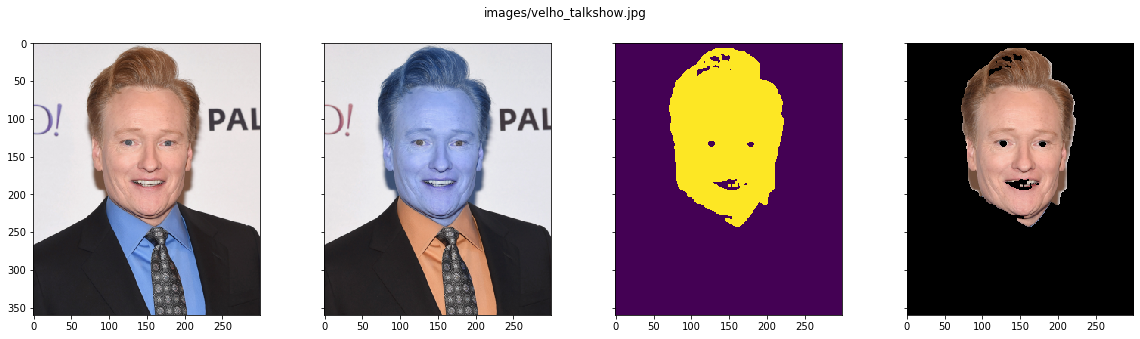

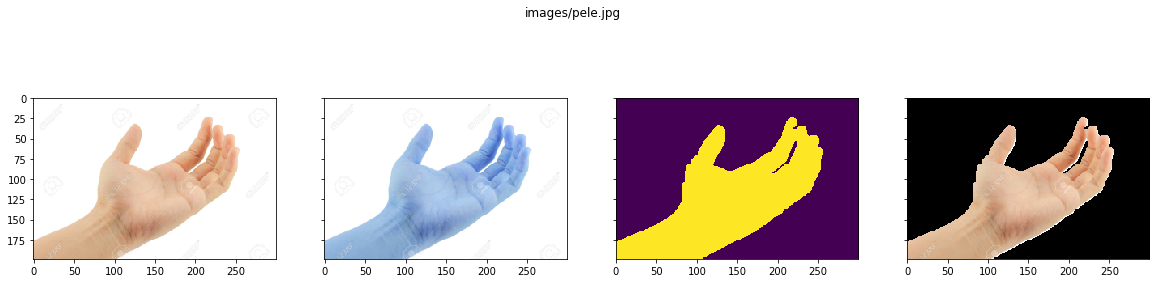

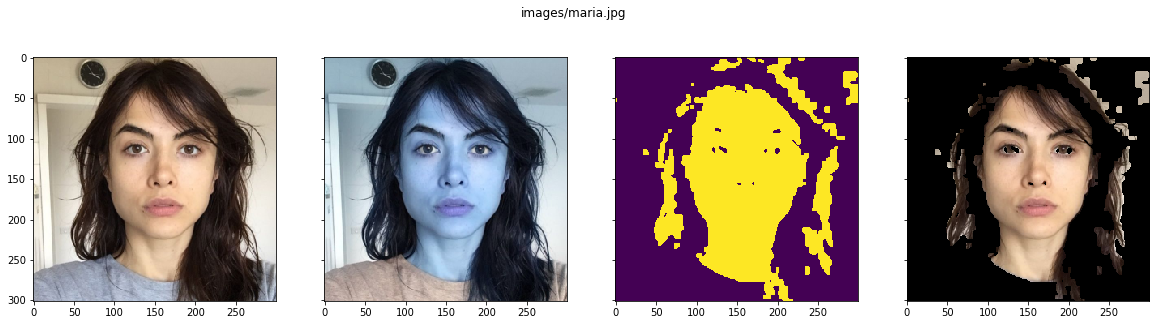

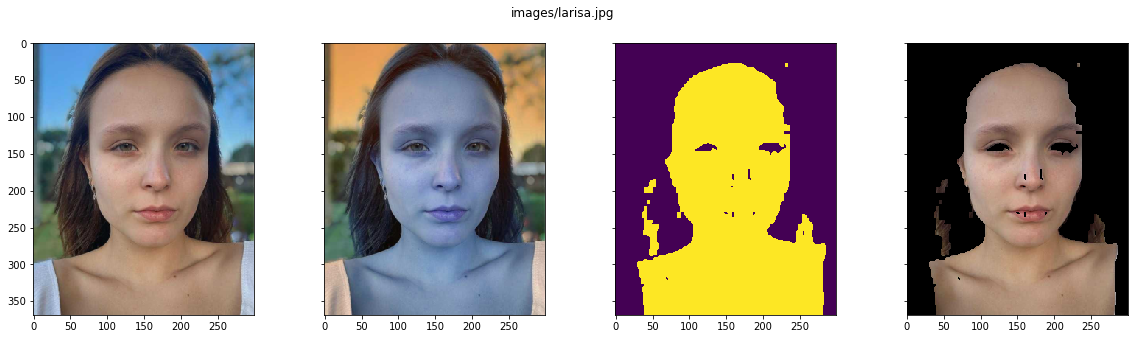

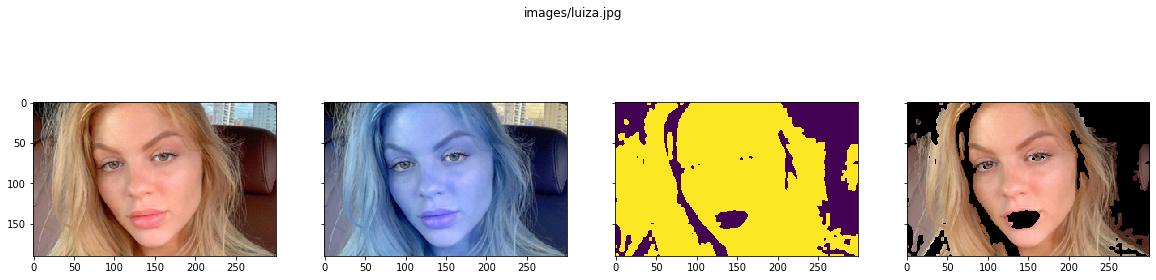

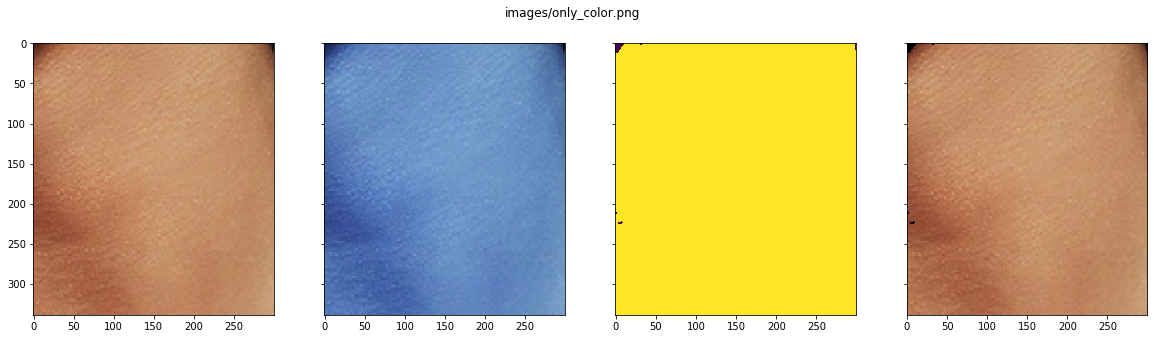

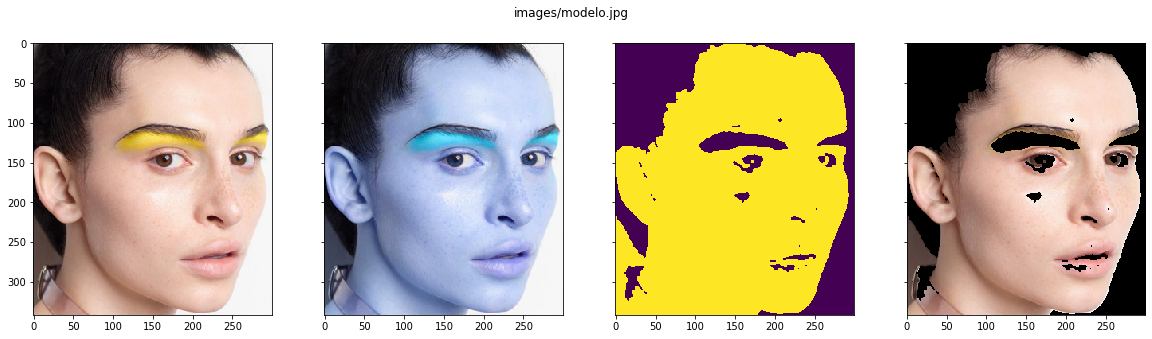

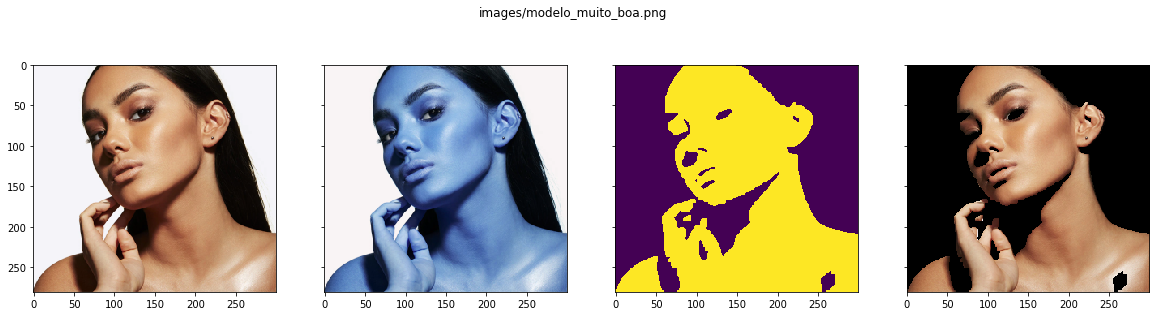

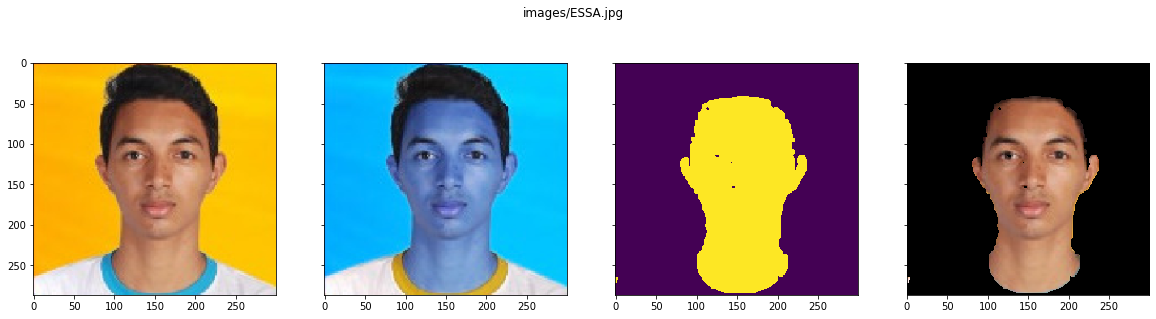

In [31]:
for index in glob('images/*'):
   
    #lendo e convertendo
    image_rgb = imread(index)
    image_rgb = imutils.resize(image_rgb, width=300)
    image_bgr = image_rgb[:, :, ::-1]

    #aplicando segmentation
    result_mask = segment_mask_face(image_bgr)
    result_mask = binary_image_with_otsu(result_mask)
    result_mask = np.invert(result_mask)
    
    result_mergex_skin = mergex_mask_rgb(result_mask, image_rgb)
    
    plot_images(index, 
                image_rgb,
                image_bgr,
                result_mask, 
                result_mergex_skin)
